Microsoft AI Rangers Demo
# Privacy Preserving Medical Image Analysis

__Pneumonia Detection in Radiographs__

<img src="images/dp-pneumonia.png" width=1000 />

Differential Privacy is the gold standard for protecting individuals' data in applications like preparing and publishing statistical analyses. Differential Privacy provides a mathematically measurable privacy guarantee to individual data subjects. 
It offers significantly higher privacy levels than commonly used disclosure limitation practices like data anonymization.

Modern deep learning architectures are especially prone to privacy risks due to their enormous capacity, often with millions (sometimes billions) of trainable parameters. Thus, there is always a tendency to memorize individual data points (or even whole datasets). This behavior is undesired not only for privacy reasons. Machine learning aims to train a model that can learn general patterns to make accurate predictions for new data points instead of memorizing the training data.

### In this notebook
The goal of this notebook is to demonstrate how to perform deep learning for medical image analysis in conjunction with differential privacy. This ensures that the contribution of the individuals (patients in this case) to the resulting machine learning model is masked out. Consequently it is not possible that information of individual patients may be leaked from the trained machine learning model.

We are using a public x-ray image dataset which includes cases with pneumonia and no finding (**normal** class). The flow of the demonstration is as follows:

1. Acquire and prepare x-ray images
2. Develop a Convolutional Neural Network (CNN) for image classification
3. Train a standard (non differentially private) model as a baseline
4. Use Differential Privacy to train a privacy preserving model
5. Compare the performance of both models
 
You can find the dataset under this location: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia. 
We have downloaded the dataset from above url and zipped the images files into the following structure:

<img src="images/dp-chestimg-folder.jpg" width = 300 />

This notebokk was developed and tested using an Azure ML NC12v3 GPU [compute instance](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-create-manage-compute-instance?tabs=python). 

## Setup
### Installs and imports

In [1]:
# AML Python 3.8 - Pytorch env used as Opacus requires Pytorch >= 3.75 
# %pip install opacus

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import time
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from opacus import PrivacyEngine

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

from utils.demoutils import dptrain, plot_learning_curve, to_categorical, print_metrics, predict_loader

### Set global variables

In [3]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(device)

# Source of compressed image dataset
ds_zip_source = 'datasets/chest-pat-2class-tvt.zip'
# Base directory to unzip the dataset
base_dir = '/home/azureuser/chest/'

seed = 1

img_height, img_width, channels = 224, 224, 1
img_mean = 0.4818
img_std = 0.2357

cuda


## Acquire and prepare x-ray images
### Create dataset on local Compute Instance filesystem
Copy the dataset to the local filesystem to improve performance. This step is required only once per Compute Instance. Set `extract = True` for extraction.

In [4]:
extract = False

if extract == True:
    from zipfile import ZipFile
    
    with ZipFile(ds_zip_source, 'r') as zipObj:
        zipObj.extractall(base_dir)

In [5]:
torch.manual_seed(seed)
transform_train = transforms.Compose([transforms.Grayscale(),
                                transforms.Resize((img_height, img_width)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = (img_mean,), std = (img_std,))    
                               ])

transform_val = transforms.Compose([transforms.Grayscale(),
                                transforms.Resize((img_height, img_width)),
                                transforms.ToTensor(),   
                                transforms.Normalize(mean = (img_mean,), std = (img_std,))    
                               ])

training_dataset = datasets.ImageFolder(root = base_dir + 'train/', transform = transform_train)
validation_dataset = datasets.ImageFolder(root = base_dir + 'val/', transform = transform_val)
test_dataset = datasets.ImageFolder(root = base_dir + 'val/', transform = transform_val)

training_loader = torch.utils.data.DataLoader(dataset = training_dataset, batch_size = 32, shuffle = True, drop_last=True)
validation_loader = torch.utils.data.DataLoader(dataset = validation_dataset, batch_size = 32, shuffle = False, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = 100, shuffle = False)

### Show examples of both classes

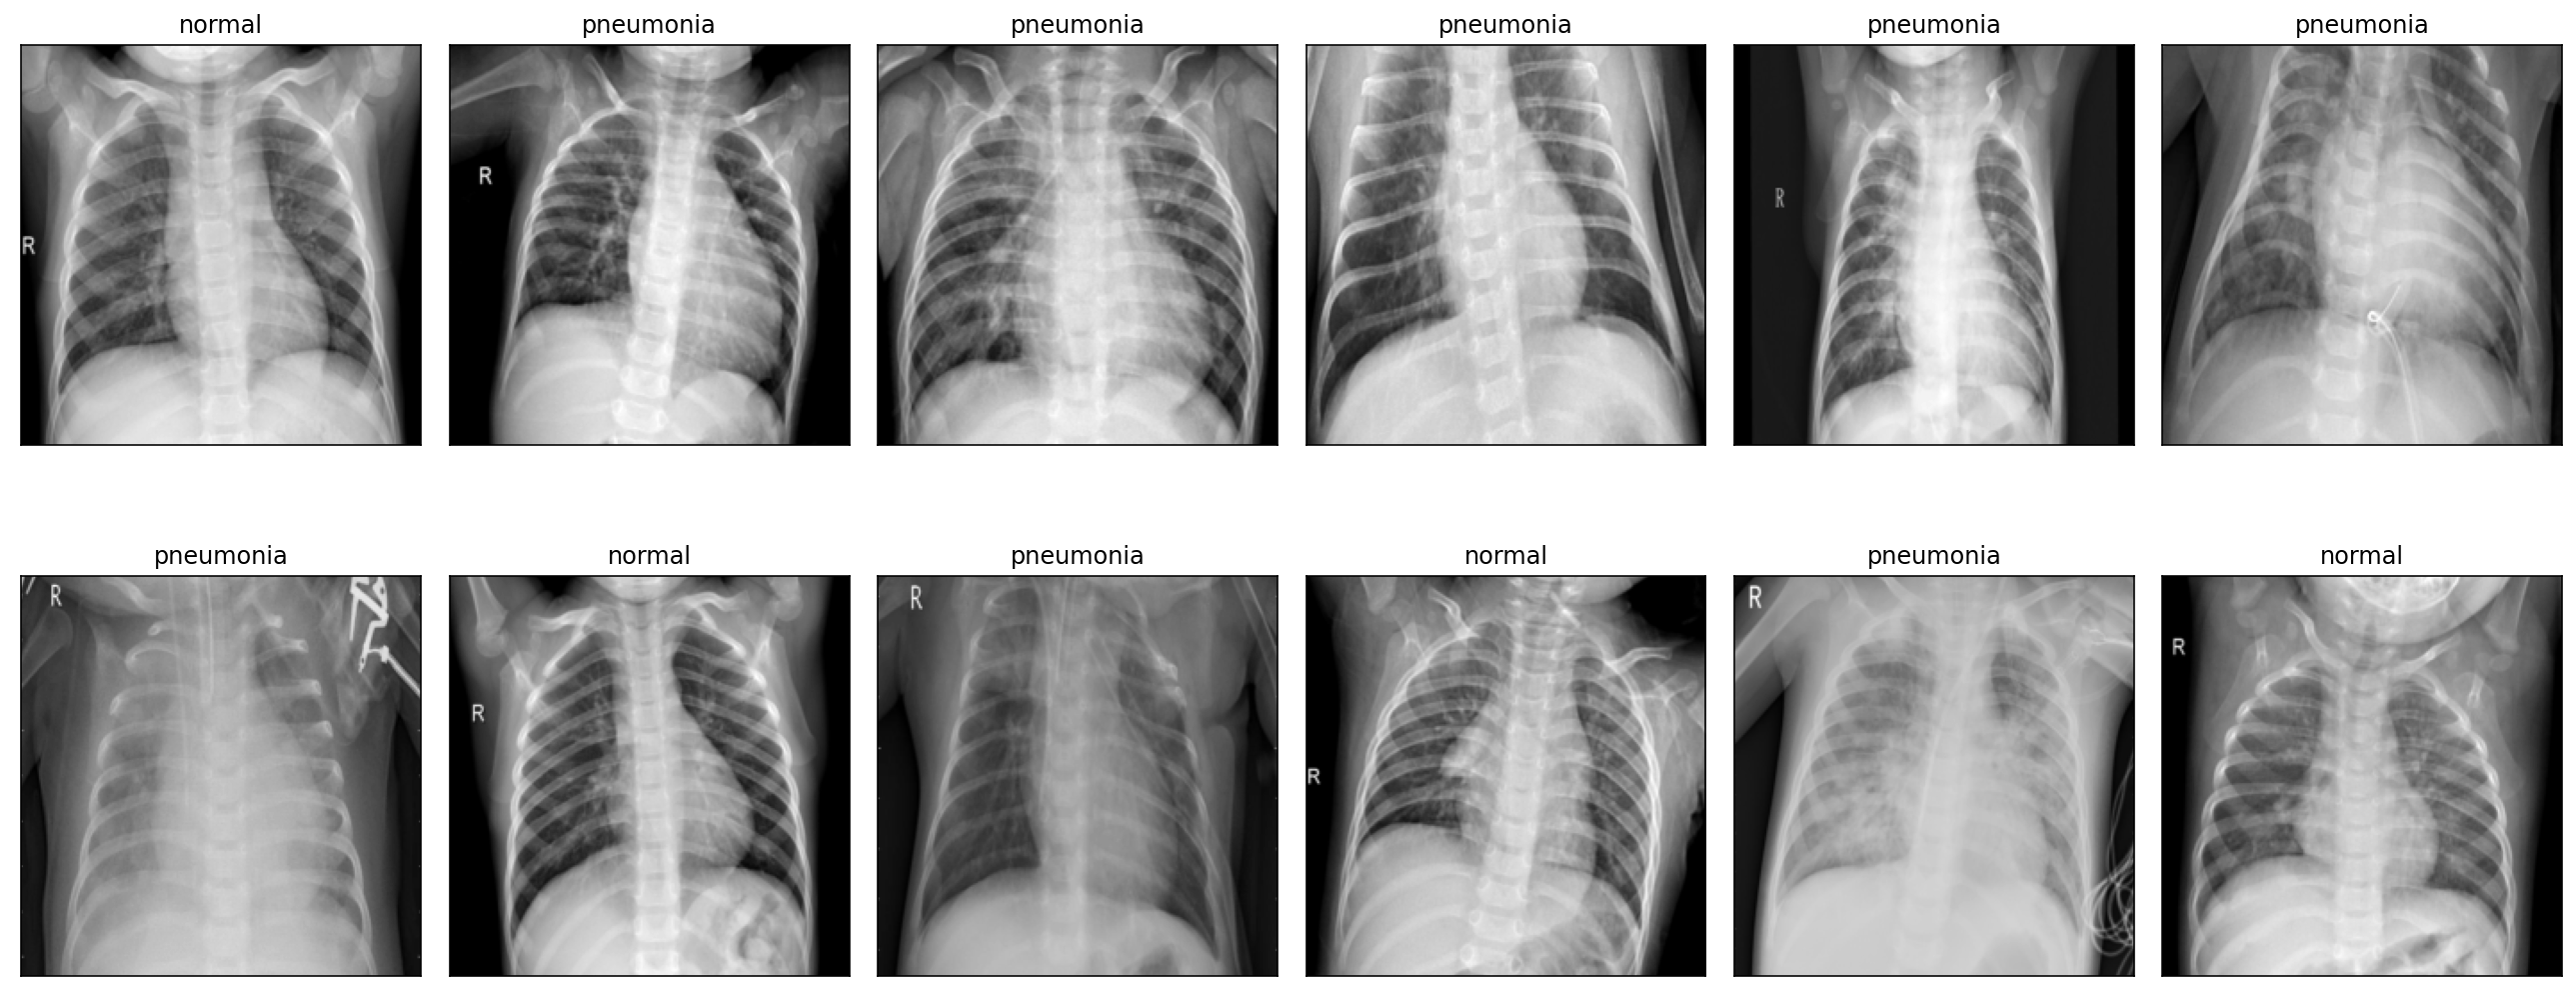

In [6]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0) # convert shape to WHC
    image = image * np.array (img_std,) + np.array(img_mean,) # revert normalization
    image = image.clip(0, 1)
    return image

dataiter = iter(training_loader)
images, labels = dataiter.next()

fig = plt.figure(figsize = (18, 8))
for idx in np.arange(12):
    ax = fig.add_subplot(2, 6, idx + 1, xticks = [], yticks = [])
    im = im_convert(images[idx]).reshape(img_height, img_width)
    plt.imshow(im , cmap = 'gray')
    ax.set_title(training_dataset.classes[labels[idx].item()])

plt.tight_layout()
plt.show()

## Develop a Convolutional Neural Network (CNN) for image classification

In [7]:
class Cnn(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 1,out_channels = 32, kernel_size = 3, stride = 1, padding=  1)
        self.conv2 = nn.Conv2d(in_channels = 32,out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv3 = nn.Conv2d(in_channels = 64,out_channels = 128, kernel_size = 3, stride = 1, padding = 1)
             
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
                
        self.fc1 = nn.Linear(28*28*128, 256)
        self.fc2 = nn.Linear(256, 2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))  # 224 x 224 x 32
        x = F.max_pool2d(x, 2, 2)  # 112 x 112 x 32
        x = F.relu(self.conv2(x))  # 112 x 112 x 64
        x = F.max_pool2d(x, 2, 2)  # 56 x 56 x 64
        x = self.dropout1(x)
        x = F.relu(self.conv3(x))  # 56 x 56 x 128
        x = F.max_pool2d(x, 2, 2)  # 28 x 28 x 128
        x = self.dropout2(x)       
        x = x.view(-1, 28*28*128) # 100.352
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

The following neural network architecture is used for training the standard (non-private) and differentailly private image classification model (to be adjusted to above architecture).

<img src="images/cnnframe.png" width=1200 />

## Train a standard (non differentially private) model as a baseline

In [8]:
model = Cnn().to(device)

torch.manual_seed(seed)

history = dptrain(model = model,
                  optimizer = torch.optim.Adam(model.parameters(), lr = 0.0007),
                  loss_fn = nn.CrossEntropyLoss(),
                  train_dl = training_loader,
                  val_dl = validation_loader,
                  epochs = 15,
                  device = device,
                  private_training = False) 


dptrain() called: model=Cnn, opt=Adam(lr=0.000700), epochs=15, device=cuda

Epoch  1/15 --- train loss: 0.20, train acc: 0.92, val loss: 0.10, val acc: 0.96
Epoch  2/15 --- train loss: 0.08, train acc: 0.97, val loss: 0.11, val acc: 0.96
Epoch  3/15 --- train loss: 0.07, train acc: 0.98, val loss: 0.07, val acc: 0.96
Epoch  4/15 --- train loss: 0.05, train acc: 0.98, val loss: 0.05, val acc: 0.98
Epoch  5/15 --- train loss: 0.04, train acc: 0.99, val loss: 0.05, val acc: 0.98
Epoch  6/15 --- train loss: 0.02, train acc: 0.99, val loss: 0.03, val acc: 0.99
Epoch  7/15 --- train loss: 0.03, train acc: 0.99, val loss: 0.07, val acc: 0.97
Epoch  8/15 --- train loss: 0.02, train acc: 0.99, val loss: 0.07, val acc: 0.97
Epoch  9/15 --- train loss: 0.02, train acc: 0.99, val loss: 0.21, val acc: 0.94
Epoch 10/15 --- train loss: 0.01, train acc: 0.99, val loss: 0.08, val acc: 0.97
Epoch 11/15 --- train loss: 0.00, train acc: 1.00, val loss: 0.04, val acc: 0.99
Epoch 12/15 --- train loss: 0.01,

### Review training progress

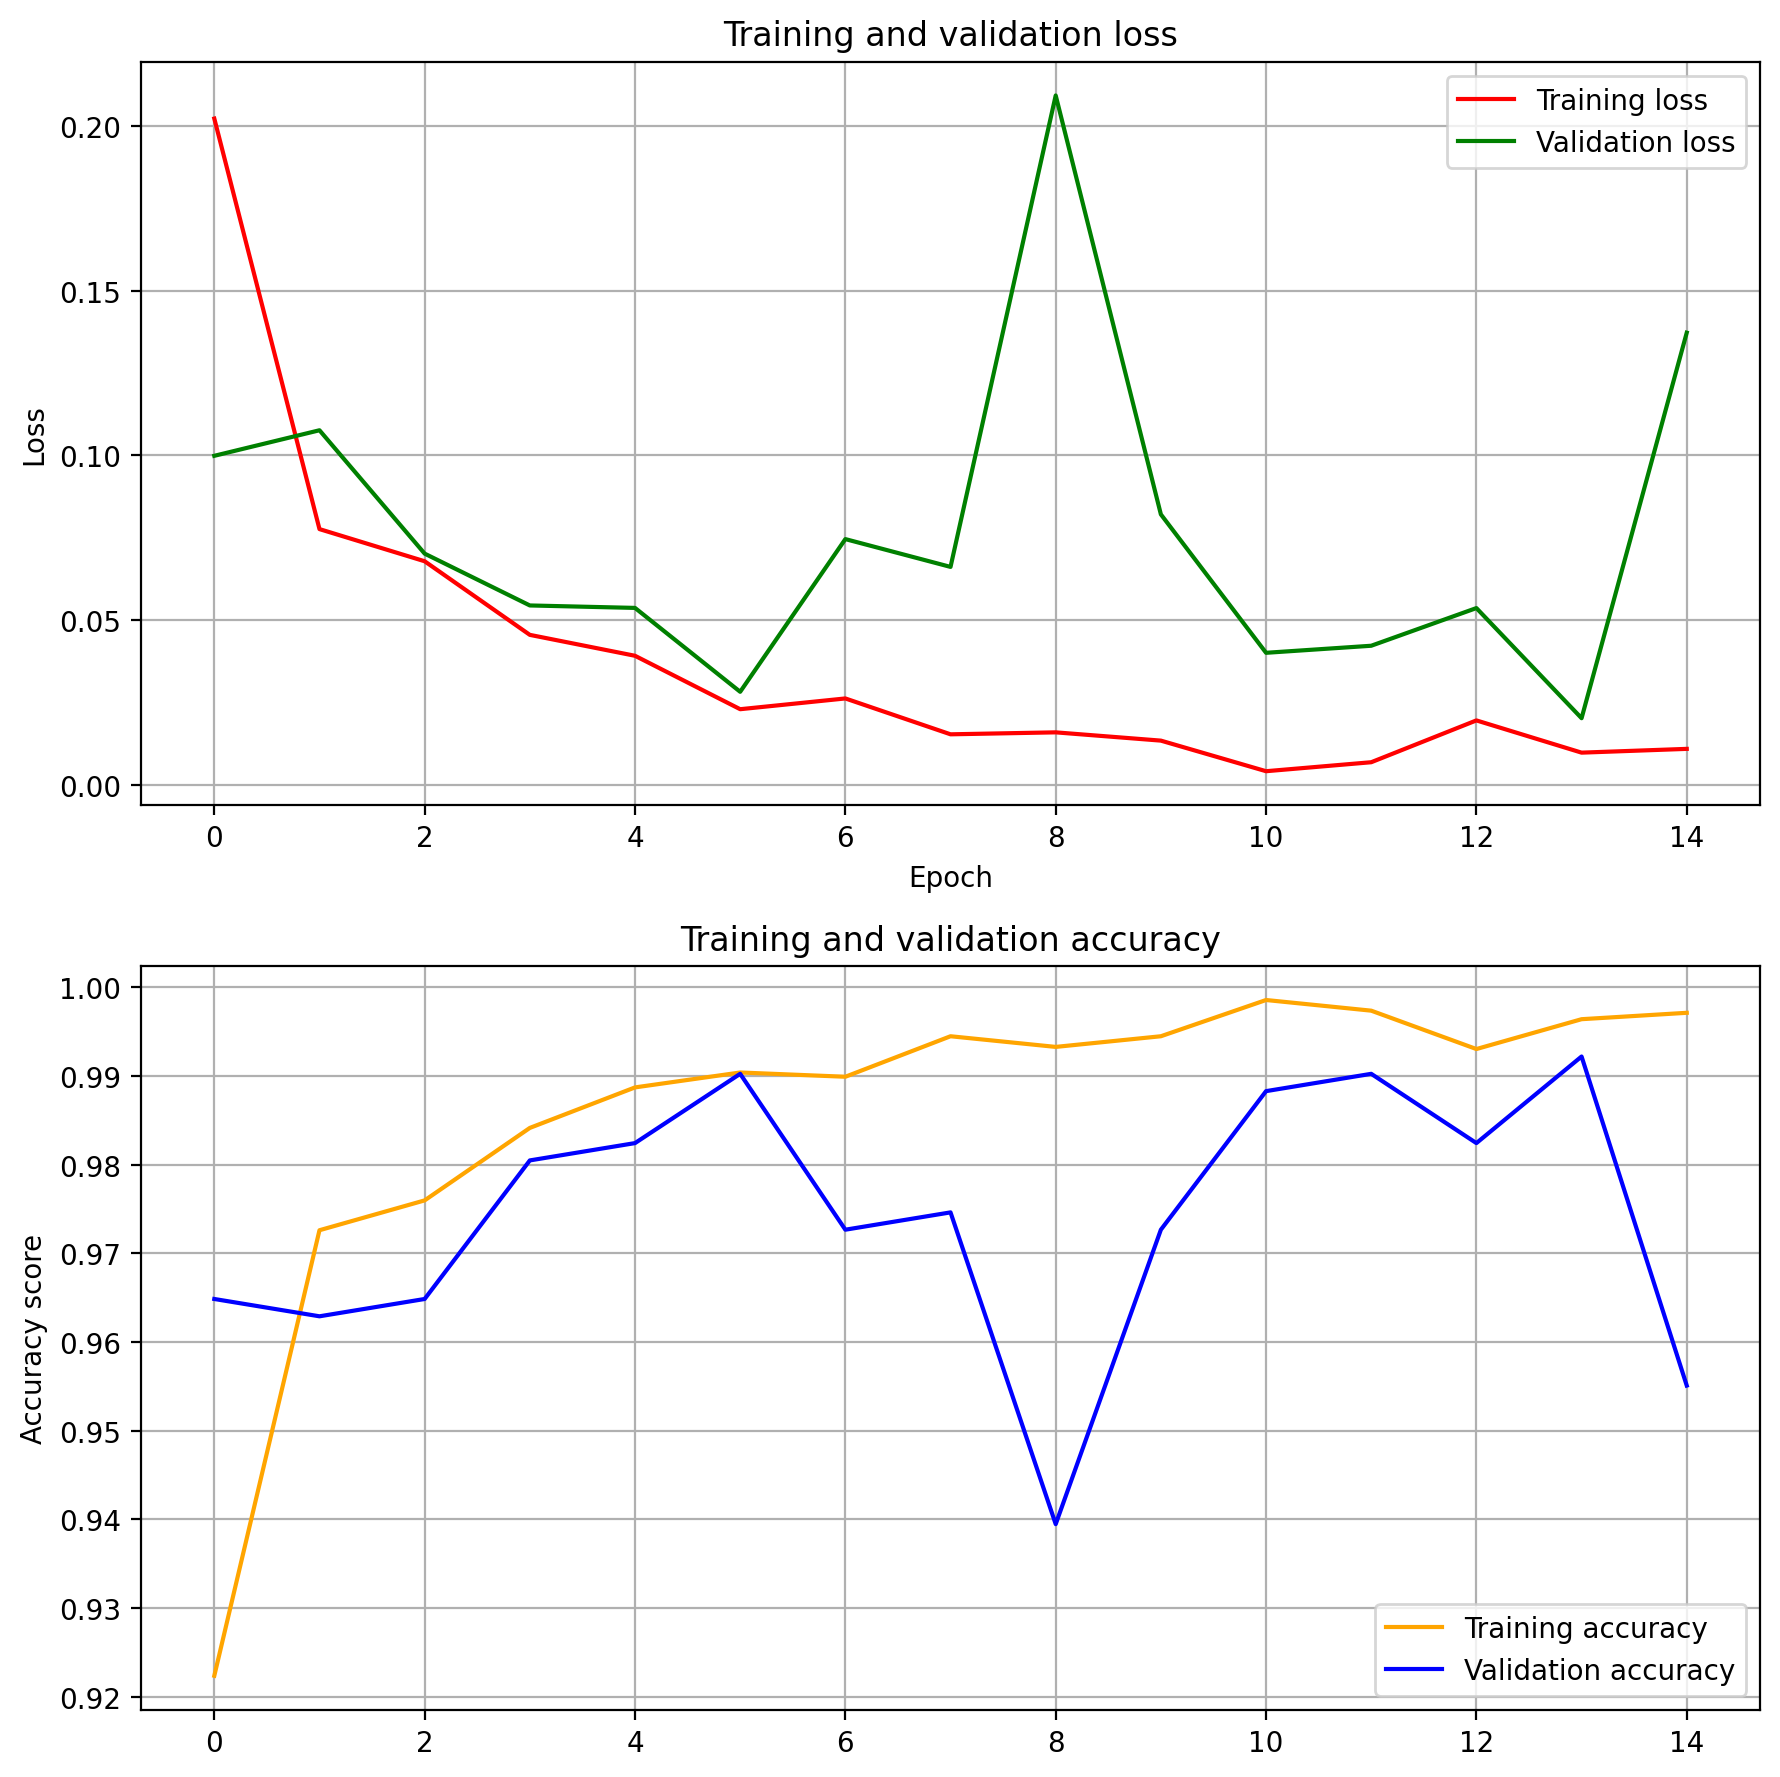

In [9]:
fig = plot_learning_curve(history)

plt.show()

In [10]:
torch.save(model, 'models/pneumonia-nonpriv.pth')

### Evaluate model based on test set

In [11]:
model = torch.load('models/pneumonia-nonpriv.pth')

In [12]:
y_true, y_pred, y_probs = predict_loader(model, test_loader, device)

y_true = y_true.cpu()
y_pred = y_pred.cpu()
y_probs = y_probs.cpu()

y_true_oh = to_categorical(y_true, num_classes = 2)
y_pred_oh = to_categorical(y_pred, num_classes = 2)

print_metrics(y_true_oh, y_pred_oh, y_probs, test_dataset.classes)

              precision    recall  f1-score   support

      normal       1.00      0.83      0.91       134
   pneumonia       0.94      1.00      0.97       385

   micro avg       0.96      0.96      0.96       519
   macro avg       0.97      0.91      0.94       519
weighted avg       0.96      0.96      0.95       519
 samples avg       0.96      0.96      0.96       519

Accuracy score: 0.956  ---  ROC AUC score: 0.999


## Use Differential Privacy to train a privacy preserving model
The following parameters need to be considered in the training process:

* Gradient clipping `max_grad_norm` limits the sensitivity of the optimizer to individual training points. It defines the upper bound of the L2 norm of the loss gradients. Therefore, the risk that the model memorizes individual data points is reduced. 
* Noise parameter `noise_multiplier` controls the amount of noise that is added to the gradients before they are applied to the optimizer. Higher values improve the privacy level but are more challenging for the training process and therefore impact accuracy. Typically set between 0.1 and 2.0.


The effect of the gradient clipping `max_grad_norm` value and noise parameter `noise_multiplier` on adjusting the gradients during the differential private training process are shown in the following illustration: 

<img src="images/dp-deep-learning.png" width=800 />

Based on the illustration by Neeraj Rajkumar Parmaar ([Differential Privacy in Deep Learning](https://towardsdatascience.com/differential-privacy-in-deep-learning-cf9cc3591d28))


In [13]:
data_loader = torch.utils.data.DataLoader(dataset = training_dataset, batch_size = 8) #, shuffle = True, drop_last=True)

model = Cnn().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0007)

privacy_engine = PrivacyEngine()

model, optimizer, data_loader = privacy_engine.make_private(
    module=model,
    optimizer=optimizer,
    data_loader=data_loader,
    noise_multiplier=0.65,
    max_grad_norm=2.0)

In [14]:
torch.manual_seed(0)

history = dptrain(model = model,
                  optimizer = optimizer,
                  loss_fn = nn.CrossEntropyLoss(),
                  train_dl = data_loader,
                  val_dl = validation_loader,
                  epochs = 15,
                  device = device,
                  private_training = True,
                  privacy_engine = privacy_engine,
                  target_delta = 1/5000)

dptrain() called: model=GradSampleModule, opt=DPOptimizer(lr=0.000700), epochs=15, device=cuda

Epoch  1/15 --- train loss: 1.17, train acc: 0.74, val loss: 0.93, val acc: 0.74 - epsilon: 1.63, best alpha: 5.10
Epoch  2/15 --- train loss: 1.11, train acc: 0.75, val loss: 0.72, val acc: 0.74 - epsilon: 1.76, best alpha: 4.90
Epoch  3/15 --- train loss: 1.00, train acc: 0.74, val loss: 0.49, val acc: 0.78 - epsilon: 1.87, best alpha: 4.80
Epoch  4/15 --- train loss: 0.75, train acc: 0.79, val loss: 0.31, val acc: 0.87 - epsilon: 1.96, best alpha: 4.80
Epoch  5/15 --- train loss: 0.56, train acc: 0.84, val loss: 0.34, val acc: 0.88 - epsilon: 2.04, best alpha: 4.70
Epoch  6/15 --- train loss: 0.58, train acc: 0.86, val loss: 0.27, val acc: 0.91 - epsilon: 2.12, best alpha: 4.70
Epoch  7/15 --- train loss: 0.57, train acc: 0.87, val loss: 0.18, val acc: 0.93 - epsilon: 2.19, best alpha: 4.60
Epoch  8/15 --- train loss: 0.70, train acc: 0.88, val loss: 0.30, val acc: 0.93 - epsilon: 2.26, b

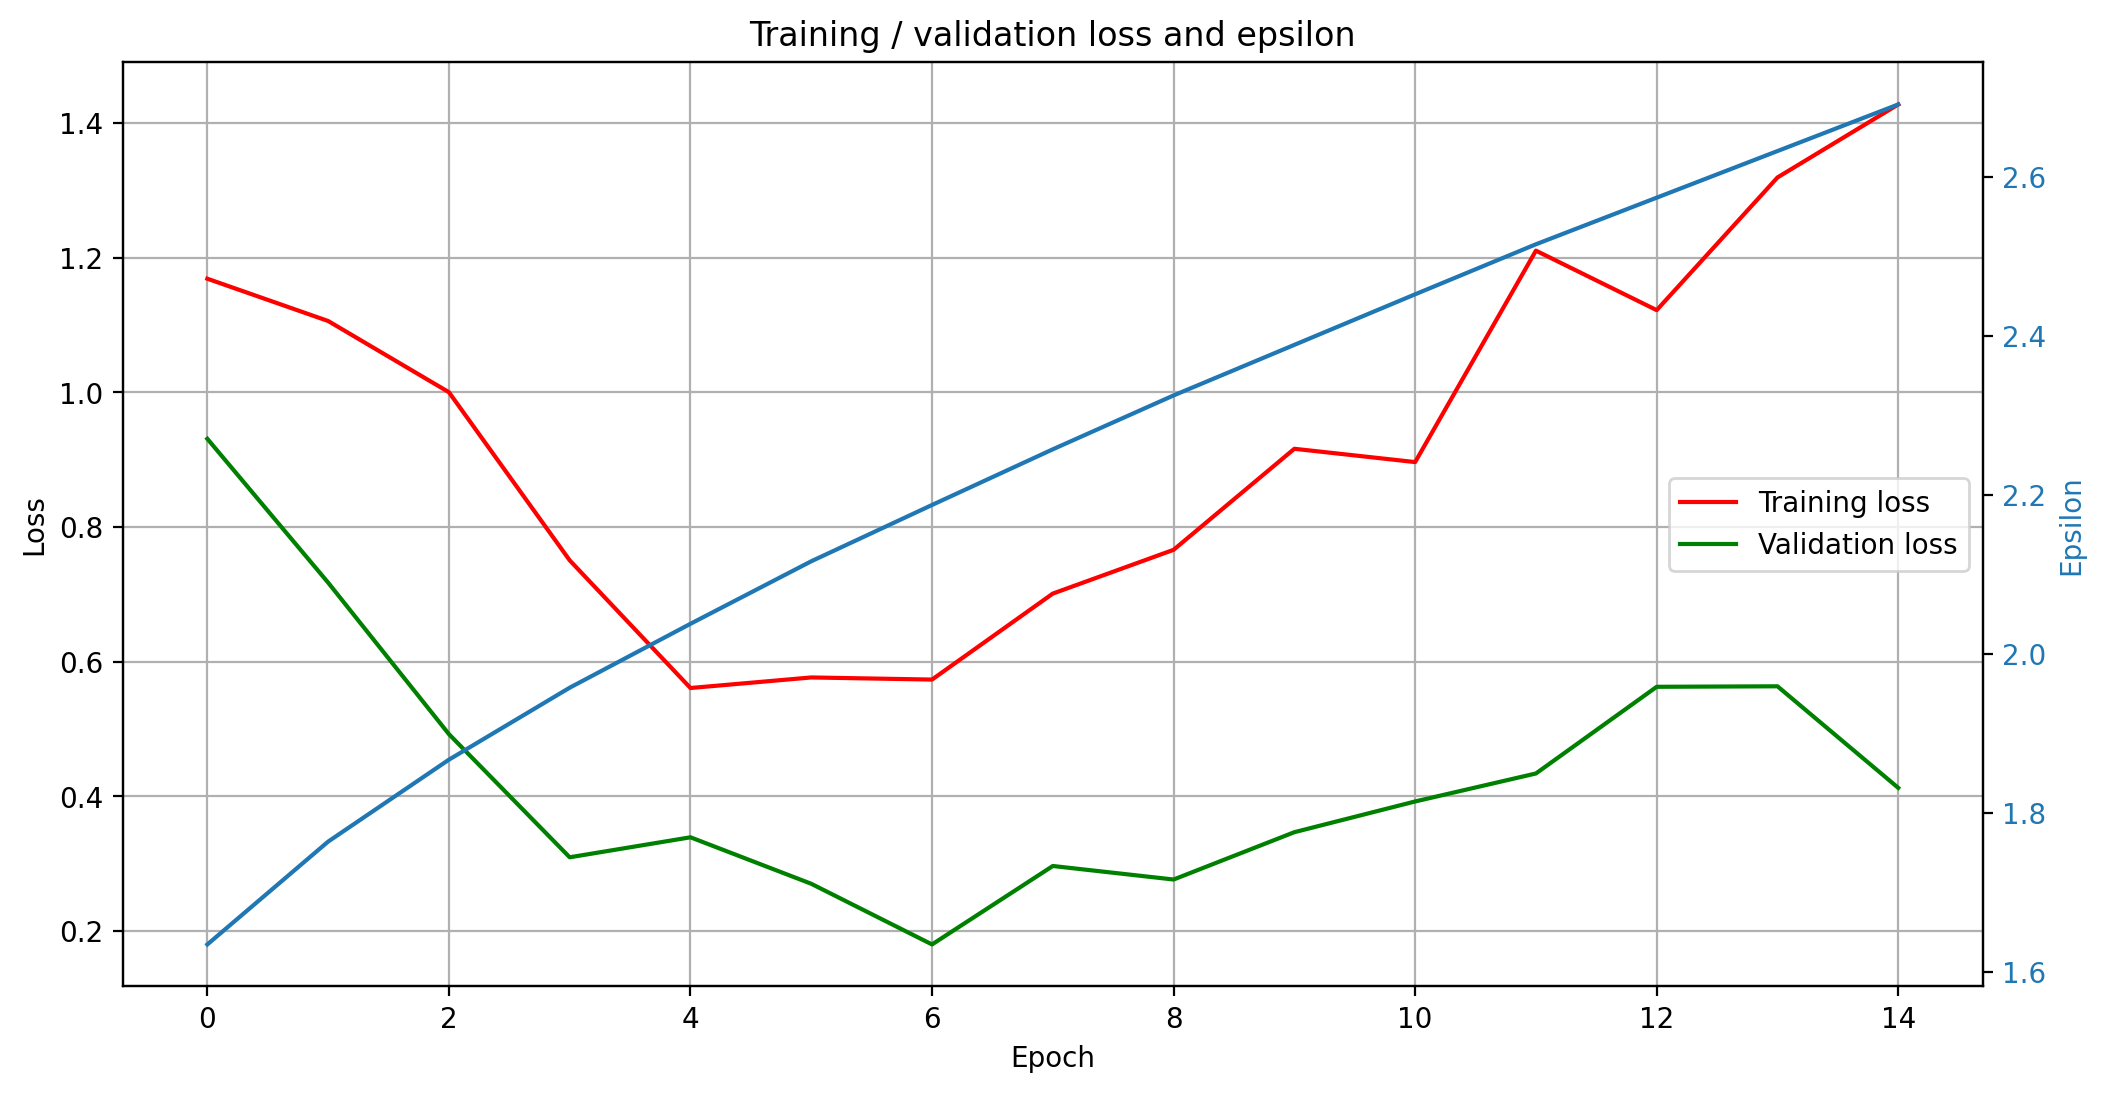

In [15]:
epochs = range(1, len(history['acc']) + 1)

fig, ax1 = plt.subplots(figsize=(12, 6))

plt.plot(history['loss'], 'red', label='Training loss')
plt.plot(history['val_loss'], 'green', label='Validation loss')
plt.legend(loc='center right')
plt.title('Training / validation loss and epsilon')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Epsilon', color=color)
ax2.plot(history['epsilon'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

<Figure size 640x480 with 0 Axes>

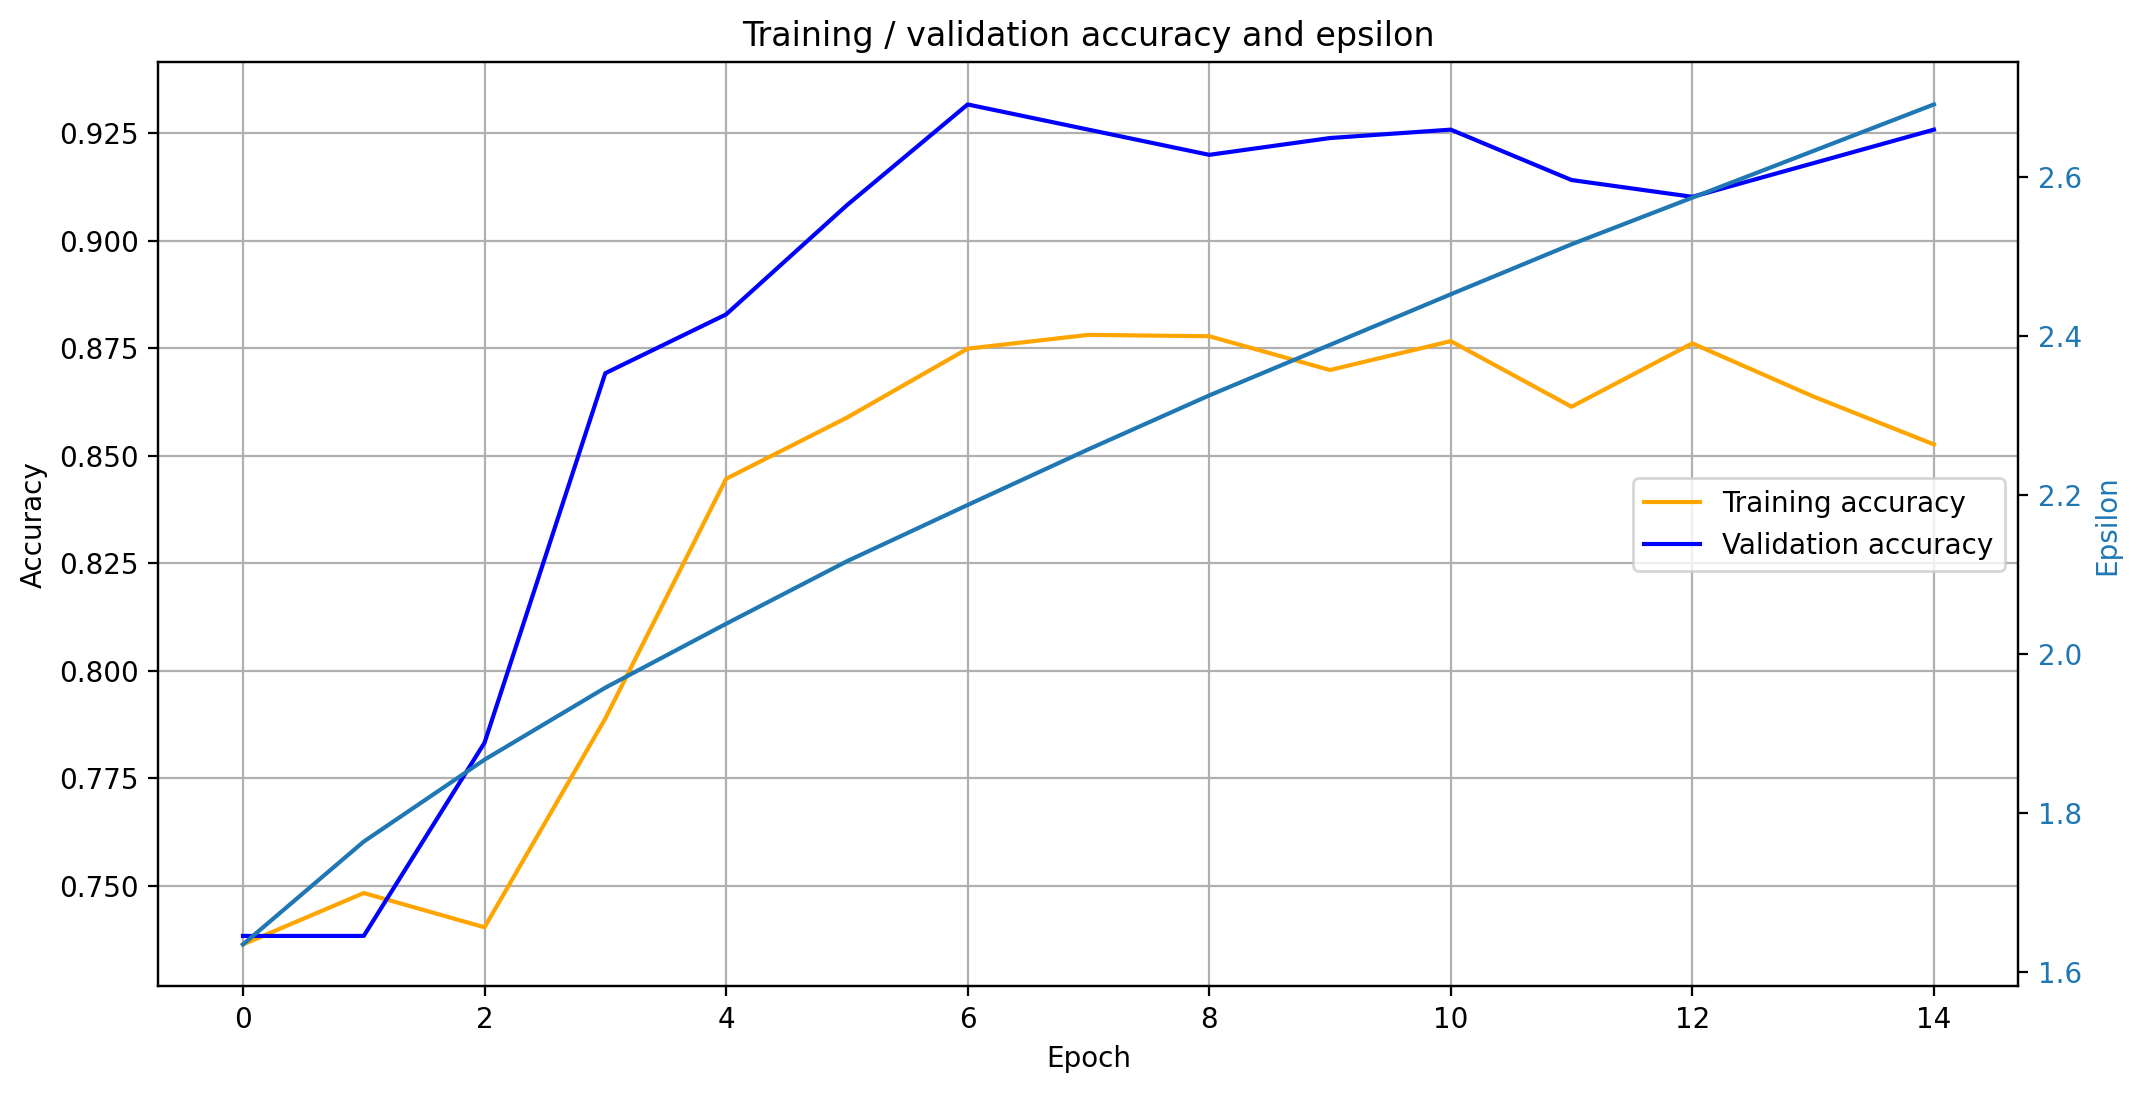

In [16]:
plt.clf()

epochs = range(1, len(history['acc']) + 1)

fig, ax1 = plt.subplots(figsize=(12, 6))

plt.plot(history['acc'], 'orange', label='Training accuracy')
plt.plot(history['val_acc'], 'blue', label='Validation accuracy')
plt.legend(loc='center right')
plt.title('Training / validation accuracy and epsilon')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Epsilon', color=color)
ax2.plot(history['epsilon'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

### Option to save / load the model

In [17]:
torch.save(model, 'models/pneumonia-dp.pth')
model = torch.load('models/pneumonia-dp.pth')

### Evaluate accuracy on test set

In [18]:
y_true, y_pred, y_probs = predict_loader(model, test_loader, device)

y_true = y_true.cpu()
y_pred = y_pred.cpu()
y_probs = y_probs.cpu()

y_true_oh = to_categorical(y_true, num_classes = 2)
y_pred_oh = to_categorical(y_pred, num_classes = 2)

print_metrics(y_true_oh, y_pred_oh, y_probs, test_dataset.classes)

              precision    recall  f1-score   support

      normal       0.88      0.83      0.85       134
   pneumonia       0.94      0.96      0.95       385

   micro avg       0.93      0.93      0.93       519
   macro avg       0.91      0.89      0.90       519
weighted avg       0.93      0.93      0.93       519
 samples avg       0.93      0.93      0.93       519

Accuracy score: 0.927  ---  ROC AUC score: 0.962


## Compare the performance of both models

In [19]:
# Get y_true from testloader and predicted propabilities from non-private model:
np_model = model = torch.load('models/pneumonia-nonpriv.pth')
y_true, _, y_probs_np = predict_loader(np_model, test_loader, device)
y_true = y_true.cpu()
y_true_oh = to_categorical(y_true, num_classes = 2)
y_probs_np = y_probs_np.cpu()

# Get predicted propabilities from DP model:
dp_model = model = torch.load('models/pneumonia-dp.pth')
_, _, y_probs_dp = predict_loader(dp_model, test_loader, device)
y_probs_dp = y_probs_dp.cpu()

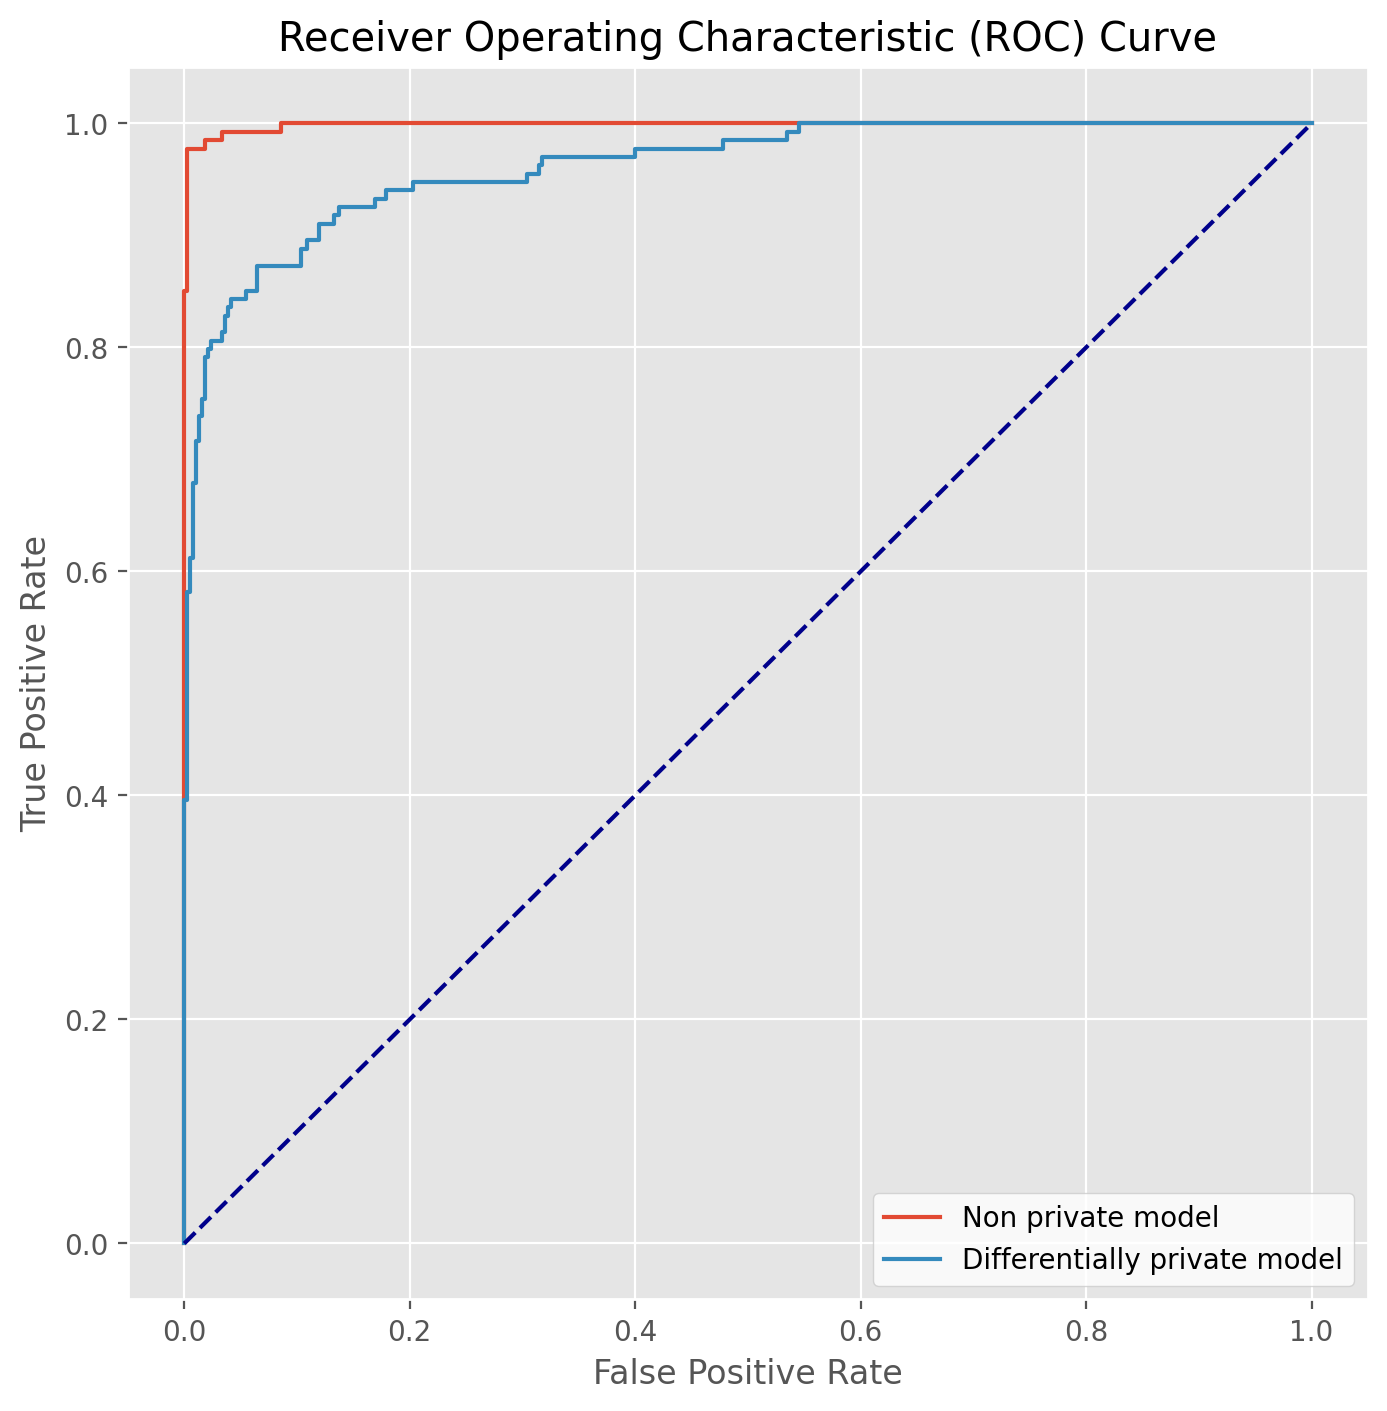

In [20]:
np_fpr, np_tpr, np_thresholds = roc_curve(y_true_oh[:,0], y_probs_np[:,0])
dp_fpr, dp_tpr, dp_thresholds = roc_curve(y_true_oh[:,0], y_probs_dp[:,0])

plt.style.use('ggplot')
fig = plt.figure(figsize=(8, 8))

plt.plot(np_fpr, np_tpr, label = 'Non private model')
plt.plot(dp_fpr, dp_tpr, label = 'Differentially private model')

plt.legend(facecolor = 'w')

plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()